#### 基本設置 + 設cuda

In [2]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision.transforms as transforms

# Define relevant variables for the ML task
batch_size = 4
num_classes = 2
learning_rate = 1e-3
num_epochs = 30

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### 讀取資料集

In [3]:
import os
import numpy as np
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset

# 定义数据转换
transform = transforms.Compose([
    # transforms.Resize((480, 256)),  # fixed image dimension
    transforms.ToTensor(),           # make np to tensor
])

# dataset
class MEL_Dataset(Dataset):
    def __init__(self, mel_folder, transform=None):
        self.melfolder = mel_folder
        self.mel_file = os.listdir(mel_folder)
        self.transform = transform
    def __len__(self):
        return len(self.mel_file)
    def __getitem__(self, idx):
        mel_file = self.mel_file[idx]
        # 範例：載入 precomputed mel tensor (n_mel, SPEC_WIDTH)
        filepath = os.path.join(self.melfolder, mel_file)
        mel = Image.open(filepath).convert('RGB')
        # make into binary classificaton
        label = 0 if int(mel_file.split('_')[0]) < 5 else 1  # 假設標籤是文件名稱的一部分
        if self.transform:
            mel = self.transform(mel)
        return mel, label


# 獲取相關信息
source_folder = '../dataset/mel_spectrograms'
dataset = MEL_Dataset(source_folder, transform=transform)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
# DataLoader for batching
for i, (mel, label) in enumerate(dataloader):
    # 在這裡進行訓練或驗證
    print(f"Batch {i}: MEL shape: {mel.shape}, Label: {label}")
    break

Batch 0: MEL shape: torch.Size([4, 3, 369, 496]), Label: tensor([0, 0, 0, 0])


Group-K fold cross validation

In [4]:
import numpy as np
from sklearn.model_selection import GroupKFold
from torch.utils.data import Subset, DataLoader

def create_group_kfold_loaders(dataset, batch_size, n_splits=5):
    """
    Split dataset using GroupKFold based on video names.
    Returns list of (train_loader, test_loader) tuples for each fold.
    """
    # Extract filenames to create groups
    mel_files = dataset.mel_file
    filenames = []
    groups = []
    labels = []

    for file in mel_files:
        # Extract video name (assuming format: label_videoname_segment.npy)
        filename = file.split('_')[1]  # Get the video name part
        filenames.append(filename)
        labels.append(0 if int(file.split('_')[0]) < 5 else 1)
    
    # Convert filenames to group indices
    unique_filenames = list(set(filenames))
    groups = [unique_filenames.index(fname) for fname in filenames]
    
    # Create indices for GroupKFold
    indices = np.arange(len(dataset))
    
    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=n_splits)
    
    # Create loaders for each fold
    fold_loaders = []
    for fold_idx, (train_idx, test_idx) in enumerate(group_kfold.split(indices, labels, groups)):
        # Create subsets for train and test
        # select specific range of data
        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)
        
        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
        
        fold_loaders.append((train_loader, test_loader, fold_idx))
    
    return fold_loaders

# Example usage
if __name__ == '__main__':
    fold_loaders = create_group_kfold_loaders(dataset, batch_size)
    
    # Now you can iterate through folds
    for train_loader, test_loader, fold_idx in fold_loaders:
        print(f"Fold {fold_idx}:")
        print(f"  Training samples: {len(train_loader.dataset)}")
        print(f"  Testing samples: {len(test_loader.dataset)}")

Fold 0:
  Training samples: 328
  Testing samples: 82
Fold 1:
  Training samples: 328
  Testing samples: 82
Fold 2:
  Training samples: 328
  Testing samples: 82
Fold 3:
  Training samples: 328
  Testing samples: 82
Fold 4:
  Training samples: 328
  Testing samples: 82


#### 創立model

In [5]:
import torch.nn.functional as F
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution , input_shape=(3,369,496)
        self.layer1 = self.input_processing_block(3, 16) #output_shape=(16,184,248)

        # 依序定義 channel 變化
        self.channel_list = [16, 64, 32, 16, 8]

        self.res_blocks = nn.ModuleList()
        for i in range(len(self.channel_list)-1):
            in_c = self.channel_list[i]
            out_c = self.channel_list[i+1]
            self.res_blocks.append(nn.ModuleDict({
                'conv': self.conv_block(in_c, out_c),
                'res': self.residue_block(in_c, out_c)
            }))

        # 用 dummy 計算 flatten_size
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 369, 496)
            out = self.layer1(dummy)
            for block in self.res_blocks:
                conv_out = block['conv'](out)
                res_out = block['res'](out)
                out = conv_out + res_out
                out = F.relu(out)
                out = nn.MaxPool2d(kernel_size=2)(out)
            self.flatten_size = out.view(1, -1).shape[1]
        # output_shape = (8, 23, 31)

        # final layers
        self.layer3 = self.classification_block(self.flatten_size, 512) #output_shape=(2,)

    def forward(self, x):
        # Convolutions
        out = self.layer1(x)

        # Apply residual connections
        for block in self.res_blocks:
            conv_out = block['conv'](out)
            res_out = block['res'](out)
            out = conv_out + res_out
            out = F.relu(out)
            out = nn.MaxPool2d(kernel_size=2)(out)

        out = self.layer3(out)

        return out
    
    def input_processing_block(self, in_channels, out_channels):
        "By giving the convolutional parameters, the function will return a convolutional module"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size=2)
        )
    def conv_block(self, in_channels, out_channels):
        "By giving the convolutional parameters, the function will return a convolutional module"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),    # expand the channels
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )
    def residue_block(self, in_channels, out_channels):
        "By giving the parameters, the function will return a residual module"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),    # expand the channels
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )

    def classification_block(self, in_channels, out_channels):
        "By giving the parameters, the function will return a classification module"
        return nn.Sequential(
            nn.Dropout(0.3),  # dropout layer
            nn.Flatten(),  # flatten the output
            nn.Linear(in_channels, out_channels),  # fully connected layer
            nn.ReLU(),
            nn.BatchNorm1d(out_channels),
            nn.Dropout(0.3),
            nn.Linear(out_channels, num_classes)  # final output layer
        )

In [6]:
import torchinfo

model = CNN_Model()
test_input = torch.randn(1, 3, 369, 496)  # Example input tensor
print(f"Model's structure:\n {torchinfo.summary(model, input_size=test_input.shape)}")

Model's structure:
Layer (type:depth-idx)                   Output Shape              Param #
CNN_Model                                [1, 2]                    --
├─Sequential: 1-1                        [1, 16, 184, 248]         --
│    └─Conv2d: 2-1                       [1, 16, 369, 496]         1,216
│    └─ReLU: 2-2                         [1, 16, 369, 496]         --
│    └─BatchNorm2d: 2-3                  [1, 16, 369, 496]         32
│    └─MaxPool2d: 2-4                    [1, 16, 184, 248]         --
├─ModuleList: 1-2                        --                        --
│    └─ModuleDict: 2-5                   --                        --
│    │    └─Sequential: 3-1              [1, 64, 184, 248]         38,272
│    │    └─Sequential: 3-2              [1, 64, 184, 248]         1,216
│    └─ModuleDict: 2-6                   --                        --
│    │    └─Sequential: 3-3              [1, 32, 92, 124]          11,456
│    │    └─Sequential: 3-4              [1, 32, 92,

#### 訓練模型

In [7]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [8]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

def training(train_loader, test_loader, optimizer, num_epochs):
    # accumlated loss to visuallized
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    # Training
    model = CNN_Model().to(device)
    optimizer = optimizer
    criterion = nn.CrossEntropyLoss()
    
    # Example training loop (simplified)
    for epoch in range(1, num_epochs+1):
        # Train mode
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        train_bar = tqdm(train_loader, desc=f"Training Epoch {epoch}/{num_epochs}")

        for iter, (input, target) in enumerate(train_bar):
            # Move data to "device".
            input = input.to(device)
            target = target.to(device)
            # Clear optimizer gradients.
            optimizer.zero_grad()
            
            # Forward pass.
            output = model(input)
            # Compute the loss.
            loss = criterion(output, target)
            # Loss backward propagation.
            loss.backward()
            # Update all learnable parameters.
            optimizer.step()
            # update training loss
            train_loss += loss.item()

            # predicted
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # Update progress bar
            train_bar.set_description(f'Epoch: {epoch}/{num_epochs} | train loss: {train_loss / total:.4f} | train accuracy: {100 * correct / total:.2f}%')

        # Calculate average training loss
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)  # Store average loss for visualization
        
        # Calculate average training accuracies
        accuracy = 100 * correct / total
        train_accuracies.append(accuracy)

        # Evaluate
        model.eval()
        BestValid = 0
        valid_loss = 0.0
        correct = 0
        total = 0
        
        valid_bar = tqdm(test_loader, desc=f"Validating Epoch {epoch}/{num_epochs}")
        with torch.no_grad():
            for inputs, targets in valid_bar:
                # run test
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs) # (batch_size, num_classes)
                # loss
                loss = criterion(outputs, targets)
                valid_loss += loss.item()
                # predicted
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

                # Update progress bar
                valid_bar.set_description(
                                            f"Epoch: {epoch}/{num_epochs} "
                                            f"| valid loss: {valid_loss / total:.4f} "
                                            f"| valid accuracy: {100 * correct / total:.2f}% "
                                        )
            
            if accuracy > BestValid:
                BestValid = accuracy
                BestValidModel = model

        # Calculate average validation loss and accuracy
        avg_valid_loss = valid_loss / len(test_loader.dataset)
        accuracy = 100 * correct / total
        
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(accuracy)

    return BestValidModel, train_losses, train_accuracies, valid_losses, valid_accuracies

In [9]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, train_accuracies, valid_losses, valid_accuracies):
    # Plot training and validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

Fold 0: Training samples: 328, Testing samples: 82


Epoch: 1/30 | train loss: 0.1966 | train accuracy: 45.12%: 100%|██████████| 82/82 [00:12<00:00,  6.54it/s]
Epoch: 1/30 | valid loss: 0.1779 | valid accuracy: 57.32% : 100%|██████████| 21/21 [00:02<00:00,  7.95it/s]
Epoch: 2/30 | train loss: 0.2031 | train accuracy: 48.48%: 100%|██████████| 82/82 [00:09<00:00,  8.36it/s]
Epoch: 2/30 | valid loss: 0.2089 | valid accuracy: 34.15% : 100%|██████████| 21/21 [00:01<00:00, 14.20it/s]
Epoch: 3/30 | train loss: 0.2002 | train accuracy: 49.09%: 100%|██████████| 82/82 [00:09<00:00,  8.48it/s]
Epoch: 3/30 | valid loss: 0.1982 | valid accuracy: 43.90% : 100%|██████████| 21/21 [00:01<00:00, 14.05it/s]
Epoch: 4/30 | train loss: 0.1953 | train accuracy: 50.61%: 100%|██████████| 82/82 [00:09<00:00,  8.37it/s]
Epoch: 4/30 | valid loss: 0.2154 | valid accuracy: 30.49% : 100%|██████████| 21/21 [00:01<00:00, 13.38it/s]
Epoch: 5/30 | train loss: 0.1962 | train accuracy: 47.26%: 100%|██████████| 82/82 [00:10<00:00,  8.19it/s]
Epoch: 5/30 | valid loss: 0.2192 

d:\ancode\envs\torch\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



Fold 0 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.00       nan      0.00         0
           1       1.00      0.38      0.55        82

    accuracy                           0.38        82
   macro avg       0.50      0.38      0.27        82
weighted avg       1.00      0.38      0.55        82

Accuracy: 0.3780
Precision: 1.0000
Recall: 0.3780
F1 Score: 0.5487
ROC AUC Score: nan
Confusion Matrix:
[[ 0  0]
 [51 31]]


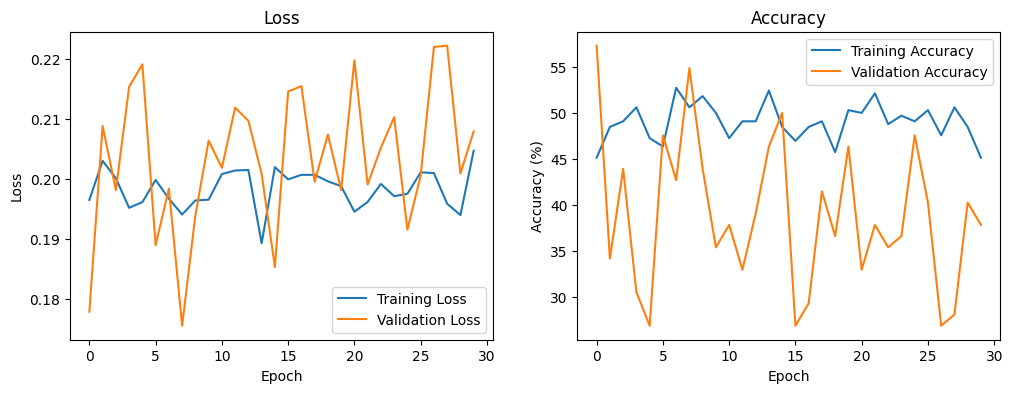

Fold 1: Training samples: 328, Testing samples: 82


Epoch: 1/30 | train loss: 0.1873 | train accuracy: 55.18%: 100%|██████████| 82/82 [00:09<00:00,  8.26it/s]
Epoch: 1/30 | valid loss: 0.2184 | valid accuracy: 46.34% : 100%|██████████| 21/21 [00:01<00:00, 14.45it/s]
Epoch: 2/30 | train loss: 0.1925 | train accuracy: 49.70%: 100%|██████████| 82/82 [00:09<00:00,  8.44it/s]
Epoch: 2/30 | valid loss: 0.1703 | valid accuracy: 60.98% : 100%|██████████| 21/21 [00:01<00:00, 14.52it/s]
Epoch: 3/30 | train loss: 0.1928 | train accuracy: 51.52%: 100%|██████████| 82/82 [00:09<00:00,  8.44it/s]
Epoch: 3/30 | valid loss: 0.1806 | valid accuracy: 54.88% : 100%|██████████| 21/21 [00:01<00:00, 14.32it/s]
Epoch: 4/30 | train loss: 0.1996 | train accuracy: 49.39%: 100%|██████████| 82/82 [00:09<00:00,  8.42it/s]
Epoch: 4/30 | valid loss: 0.1709 | valid accuracy: 53.66% : 100%|██████████| 21/21 [00:01<00:00, 13.98it/s]
Epoch: 5/30 | train loss: 0.1881 | train accuracy: 52.74%: 100%|██████████| 82/82 [00:09<00:00,  8.47it/s]
Epoch: 5/30 | valid loss: 0.1582 



Fold 1 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.67      0.78        75
           1       0.11      0.43      0.17         7

    accuracy                           0.65        82
   macro avg       0.52      0.55      0.47        82
weighted avg       0.86      0.65      0.72        82

Accuracy: 0.6463
Precision: 0.1071
Recall: 0.4286
F1 Score: 0.1714
ROC AUC Score: 0.5619
Confusion Matrix:
[[50 25]
 [ 4  3]]


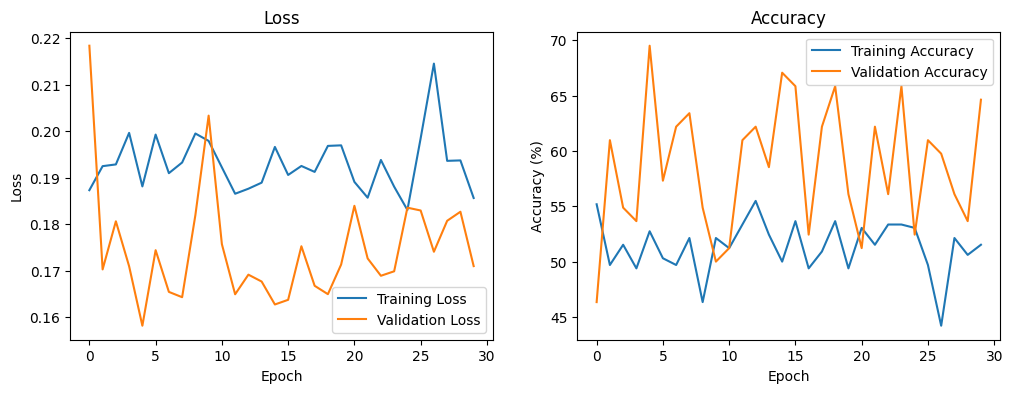

Fold 2: Training samples: 328, Testing samples: 82


Epoch: 1/30 | train loss: 0.1939 | train accuracy: 53.35%: 100%|██████████| 82/82 [00:10<00:00,  8.04it/s]
Epoch: 1/30 | valid loss: 0.1549 | valid accuracy: 64.63% : 100%|██████████| 21/21 [00:01<00:00, 13.98it/s]
Epoch: 2/30 | train loss: 0.1837 | train accuracy: 55.79%: 100%|██████████| 82/82 [00:09<00:00,  8.32it/s]
Epoch: 2/30 | valid loss: 0.1705 | valid accuracy: 59.76% : 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]
Epoch: 3/30 | train loss: 0.1887 | train accuracy: 52.44%: 100%|██████████| 82/82 [00:09<00:00,  8.30it/s]
Epoch: 3/30 | valid loss: 0.1931 | valid accuracy: 42.68% : 100%|██████████| 21/21 [00:01<00:00, 13.37it/s]
Epoch: 4/30 | train loss: 0.1911 | train accuracy: 53.96%: 100%|██████████| 82/82 [00:09<00:00,  8.36it/s]
Epoch: 4/30 | valid loss: 0.1815 | valid accuracy: 53.66% : 100%|██████████| 21/21 [00:01<00:00, 14.19it/s]
Epoch: 5/30 | train loss: 0.1885 | train accuracy: 53.05%: 100%|██████████| 82/82 [00:09<00:00,  8.24it/s]
Epoch: 5/30 | valid loss: 0.1790 



Fold 2 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.45      0.61        73
           1       0.15      0.78      0.25         9

    accuracy                           0.49        82
   macro avg       0.55      0.61      0.43        82
weighted avg       0.86      0.49      0.57        82

Accuracy: 0.4878
Precision: 0.1489
Recall: 0.7778
F1 Score: 0.2500
ROC AUC Score: 0.7078
Confusion Matrix:
[[33 40]
 [ 2  7]]


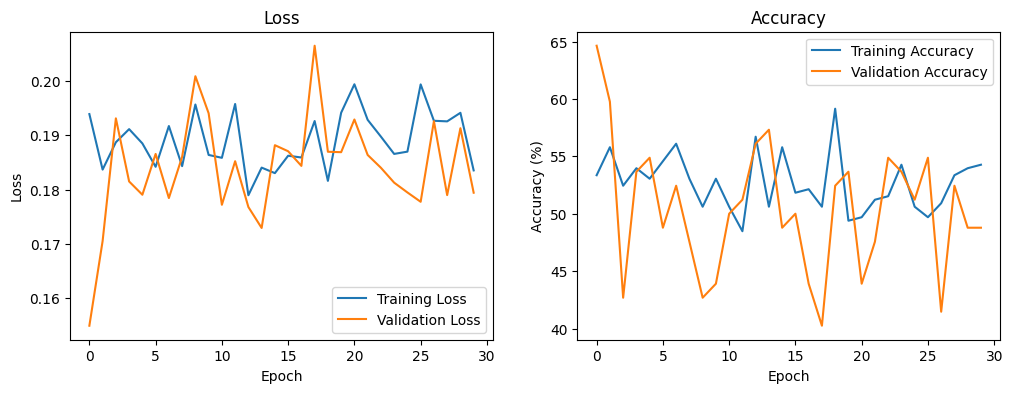

Fold 3: Training samples: 328, Testing samples: 82


Epoch: 1/30 | train loss: 0.1929 | train accuracy: 49.09%: 100%|██████████| 82/82 [00:10<00:00,  7.83it/s]
Epoch: 1/30 | valid loss: 0.2595 | valid accuracy: 19.51% : 100%|██████████| 21/21 [00:01<00:00, 13.23it/s]
Epoch: 2/30 | train loss: 0.2049 | train accuracy: 44.51%: 100%|██████████| 82/82 [00:09<00:00,  8.25it/s]
Epoch: 2/30 | valid loss: 0.2081 | valid accuracy: 28.05% : 100%|██████████| 21/21 [00:01<00:00, 14.86it/s]
Epoch: 3/30 | train loss: 0.1988 | train accuracy: 48.17%: 100%|██████████| 82/82 [00:09<00:00,  8.31it/s]
Epoch: 3/30 | valid loss: 0.2023 | valid accuracy: 37.80% : 100%|██████████| 21/21 [00:01<00:00, 14.43it/s]
Epoch: 4/30 | train loss: 0.1975 | train accuracy: 45.43%: 100%|██████████| 82/82 [00:09<00:00,  8.55it/s]
Epoch: 4/30 | valid loss: 0.1919 | valid accuracy: 40.24% : 100%|██████████| 21/21 [00:01<00:00, 14.21it/s]
Epoch: 5/30 | train loss: 0.1923 | train accuracy: 48.78%: 100%|██████████| 82/82 [00:09<00:00,  8.47it/s]
Epoch: 5/30 | valid loss: 0.1978 



Fold 3 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.47      0.60        72
           1       0.07      0.30      0.12        10

    accuracy                           0.45        82
   macro avg       0.45      0.39      0.36        82
weighted avg       0.74      0.45      0.54        82

Accuracy: 0.4512
Precision: 0.0732
Recall: 0.3000
F1 Score: 0.1176
ROC AUC Score: 0.3625
Confusion Matrix:
[[34 38]
 [ 7  3]]


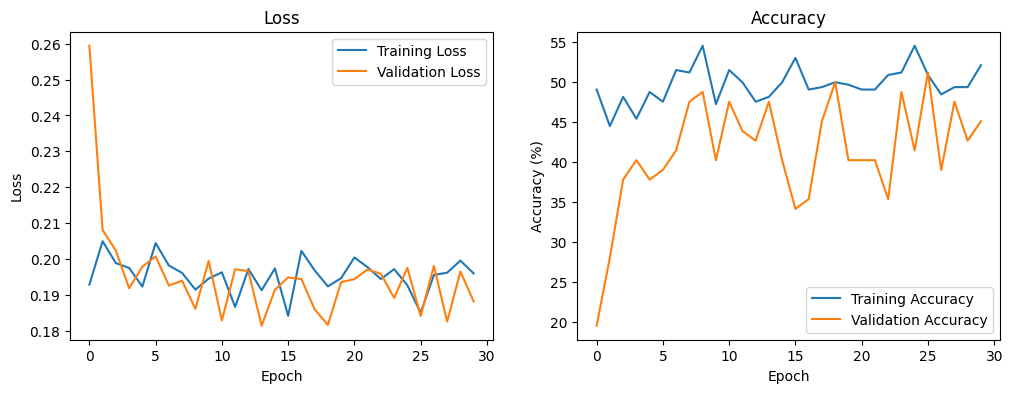

Fold 4: Training samples: 328, Testing samples: 82


Epoch: 1/30 | train loss: 0.1996 | train accuracy: 50.00%: 100%|██████████| 82/82 [00:09<00:00,  8.42it/s]
Epoch: 1/30 | valid loss: 0.1450 | valid accuracy: 78.05% : 100%|██████████| 21/21 [00:01<00:00, 14.97it/s]
Epoch: 2/30 | train loss: 0.1926 | train accuracy: 52.13%: 100%|██████████| 82/82 [00:09<00:00,  8.47it/s]
Epoch: 2/30 | valid loss: 0.1691 | valid accuracy: 67.07% : 100%|██████████| 21/21 [00:01<00:00, 14.86it/s]
Epoch: 3/30 | train loss: 0.2015 | train accuracy: 52.44%: 100%|██████████| 82/82 [00:09<00:00,  8.54it/s]
Epoch: 3/30 | valid loss: 0.1425 | valid accuracy: 78.05% : 100%|██████████| 21/21 [00:01<00:00, 14.57it/s]
Epoch: 4/30 | train loss: 0.1930 | train accuracy: 50.30%: 100%|██████████| 82/82 [00:09<00:00,  8.43it/s]
Epoch: 4/30 | valid loss: 0.1602 | valid accuracy: 67.07% : 100%|██████████| 21/21 [00:01<00:00, 15.03it/s]
Epoch: 5/30 | train loss: 0.2045 | train accuracy: 49.09%: 100%|██████████| 82/82 [00:09<00:00,  8.52it/s]
Epoch: 5/30 | valid loss: 0.1543 



Fold 4 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        74
           1       0.17      0.38      0.23         8

    accuracy                           0.76        82
   macro avg       0.54      0.59      0.54        82
weighted avg       0.85      0.76      0.79        82

Accuracy: 0.7561
Precision: 0.1667
Recall: 0.3750
F1 Score: 0.2308
ROC AUC Score: 0.6757
Confusion Matrix:
[[59 15]
 [ 5  3]]


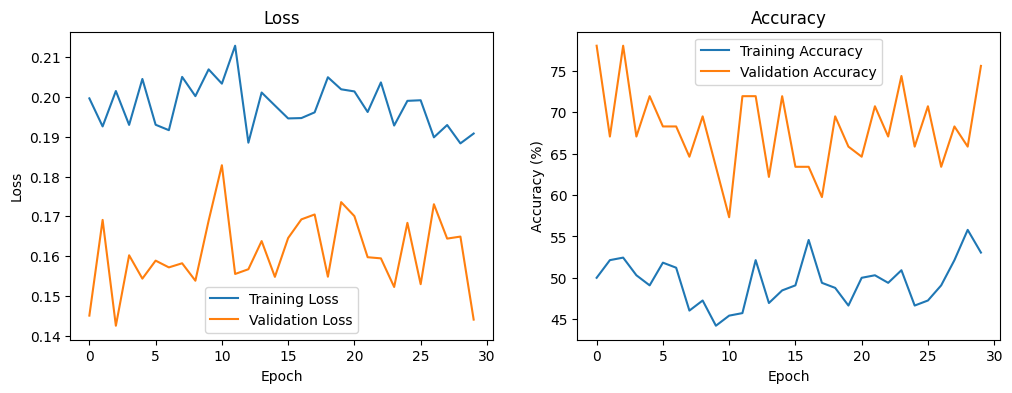

Best Validation Accuracy: 78.05% in Fold 4


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
# File name.
modelSaveName = "MELModel.pt"
# model
model = CNN_Model().to(device)
# Create an optimizer.
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
# Create a loss function
lossFunc = nn.CrossEntropyLoss()

BestValid_Acc = 0
Bestfold = 0
fold_loaders = create_group_kfold_loaders(dataset, batch_size)
for train, test, idx in fold_loaders:
    print(f"Fold {idx}: Training samples: {len(train.dataset)}, Testing samples: {len(test.dataset)}")
    model, train_losses, train_accuracies, valid_losses, valid_accuracies = training(train, test, optimizer, num_epochs)
    print()

    # Print statistics for this fold
    all_targets = []
    all_predictions = []
    all_probs = []
    
    # Set model to evaluation mode
    model.eval()
    
    # Collect predictions for test data
    with torch.no_grad():
        for inputs, targets in test:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            
            # Get probability scores for ROC AUC
            probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[:, 1]  # Probability for positive class
            
            # Store results for metrics calculation
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs)
    
    # Calculate metrics
    try:
        roc_auc_score_value = roc_auc_score(all_targets, all_probs)
    except ValueError:
        # Handle case when only one class is present in targets
        roc_auc_score_value = 0.5
    
    # Generate confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    # Print detailed metrics
    print(f"\nFold {idx} Test Results:")
    
    print(f"Classification Report:\n{classification_report(all_targets, all_predictions, zero_division=np.nan)}")
    print(f"Accuracy: {accuracy_score(all_targets, all_predictions):.4f}")
    print(f"Precision: {precision_score(all_targets, all_predictions):.4f}")
    print(f"Recall: {recall_score(all_targets, all_predictions):.4f}")
    print(f"F1 Score: {f1_score(all_targets, all_predictions):.4f}")
    print(f"ROC AUC Score: {roc_auc_score_value:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # Plot the training history
    plot_training_history(train_losses, train_accuracies, valid_losses, valid_accuracies)
    plt.show()

    # Check for best validation accuracy to store best model
    if max(valid_accuracies) > BestValid_Acc:
        BestValid_Acc = max(valid_accuracies)
        Bestfold = idx
        modelToSave = model


# 存檔
print(f"Best Validation Accuracy: {BestValid_Acc:.2f}% in Fold {Bestfold}")
# torch.save(modelToSave.state_dict(), modelSaveName)
# print('Model saved to %s' % modelSaveName)

Test Adam

Fold 0: Training samples: 328, Testing samples: 82


Epoch: 1/30 | train loss: 0.0540 | train accuracy: 44.51%: 100%|██████████| 21/21 [00:15<00:00,  1.39it/s]
Epoch: 1/30 | valid loss: 0.0260 | valid accuracy: 100.00% : 100%|██████████| 6/6 [00:01<00:00,  4.16it/s]
Epoch: 2/30 | train loss: 0.0551 | train accuracy: 43.60%: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]
Epoch: 2/30 | valid loss: 0.0261 | valid accuracy: 100.00% : 100%|██████████| 6/6 [00:01<00:00,  4.16it/s]
Epoch: 3/30 | train loss: 0.0542 | train accuracy: 44.82%: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]
Epoch: 3/30 | valid loss: 0.0336 | valid accuracy: 96.34% : 100%|██████████| 6/6 [00:01<00:00,  4.08it/s]
Epoch: 4/30 | train loss: 0.0541 | train accuracy: 46.04%: 100%|██████████| 21/21 [00:09<00:00,  2.11it/s]
Epoch: 4/30 | valid loss: 0.0414 | valid accuracy: 84.15% : 100%|██████████| 6/6 [00:01<00:00,  4.17it/s] 
Epoch: 5/30 | train loss: 0.0537 | train accuracy: 42.99%: 100%|██████████| 21/21 [00:09<00:00,  2.10it/s]
Epoch: 5/30 | valid loss: 0.0400 | val

d:\ancode\envs\torch\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



Fold 0 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.00       nan      0.00         0
           1       1.00      0.70      0.82        82

    accuracy                           0.70        82
   macro avg       0.50      0.70      0.41        82
weighted avg       1.00      0.70      0.82        82

Accuracy: 0.6951
Precision: 1.0000
Recall: 0.6951
F1 Score: 0.8201
ROC AUC Score: nan
Confusion Matrix:
[[ 0  0]
 [25 57]]


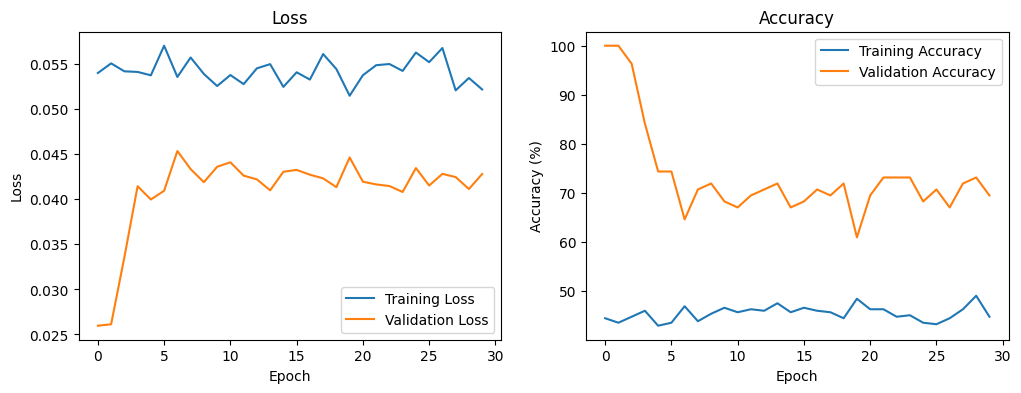

Fold 1: Training samples: 328, Testing samples: 82


Epoch: 1/30 | train loss: 0.0511 | train accuracy: 46.95%: 100%|██████████| 21/21 [00:10<00:00,  2.05it/s]
Epoch: 1/30 | valid loss: 0.0764 | valid accuracy: 8.54% : 100%|██████████| 6/6 [00:01<00:00,  4.13it/s]
Epoch: 2/30 | train loss: 0.0497 | train accuracy: 51.22%: 100%|██████████| 21/21 [00:09<00:00,  2.11it/s]
Epoch: 2/30 | valid loss: 0.0732 | valid accuracy: 8.54% : 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]
Epoch: 3/30 | train loss: 0.0515 | train accuracy: 46.65%: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]
Epoch: 3/30 | valid loss: 0.0603 | valid accuracy: 28.05% : 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]
Epoch: 4/30 | train loss: 0.0521 | train accuracy: 47.56%: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]
Epoch: 4/30 | valid loss: 0.0634 | valid accuracy: 25.61% : 100%|██████████| 6/6 [00:01<00:00,  4.39it/s]
Epoch: 5/30 | train loss: 0.0534 | train accuracy: 43.29%: 100%|██████████| 21/21 [00:10<00:00,  1.94it/s]
Epoch: 5/30 | valid loss: 0.0652 | valid ac



Fold 1 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.20      0.32        75
           1       0.05      0.43      0.09         7

    accuracy                           0.22        82
   macro avg       0.42      0.31      0.20        82
weighted avg       0.73      0.22      0.30        82

Accuracy: 0.2195
Precision: 0.0476
Recall: 0.4286
F1 Score: 0.0857
ROC AUC Score: 0.3886
Confusion Matrix:
[[15 60]
 [ 4  3]]


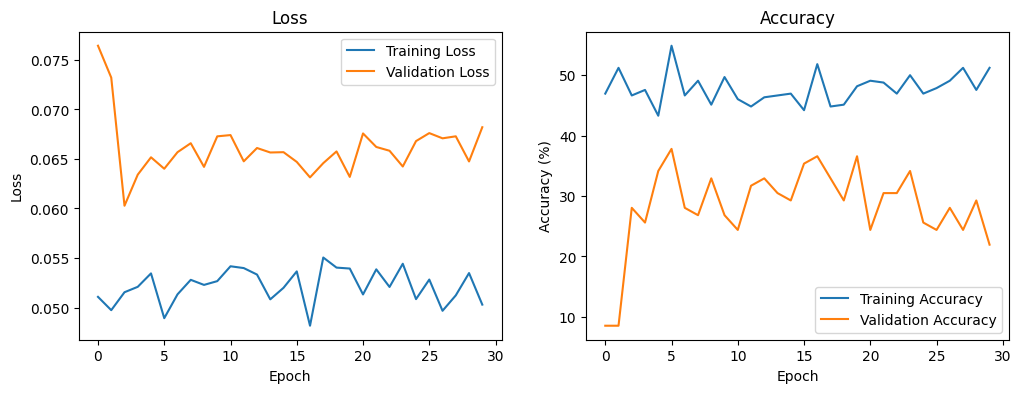

Fold 2: Training samples: 328, Testing samples: 82


Epoch: 1/30 | train loss: 0.0538 | train accuracy: 46.65%: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]
Epoch: 1/30 | valid loss: 0.0423 | valid accuracy: 89.02% : 100%|██████████| 6/6 [00:01<00:00,  4.34it/s] 
Epoch: 2/30 | train loss: 0.0545 | train accuracy: 45.73%: 100%|██████████| 21/21 [00:09<00:00,  2.14it/s]
Epoch: 2/30 | valid loss: 0.0420 | valid accuracy: 89.02% : 100%|██████████| 6/6 [00:01<00:00,  4.27it/s] 
Epoch: 3/30 | train loss: 0.0503 | train accuracy: 45.43%: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]
Epoch: 3/30 | valid loss: 0.0436 | valid accuracy: 87.80% : 100%|██████████| 6/6 [00:01<00:00,  4.23it/s] 
Epoch: 4/30 | train loss: 0.0523 | train accuracy: 47.26%: 100%|██████████| 21/21 [00:09<00:00,  2.14it/s]
Epoch: 4/30 | valid loss: 0.0454 | valid accuracy: 82.93% : 100%|██████████| 6/6 [00:01<00:00,  4.36it/s] 
Epoch: 5/30 | train loss: 0.0522 | train accuracy: 44.82%: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]
Epoch: 5/30 | valid loss: 0.0536 | va



Fold 2 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.51      0.63        73
           1       0.05      0.22      0.09         9

    accuracy                           0.48        82
   macro avg       0.45      0.36      0.36        82
weighted avg       0.75      0.48      0.57        82

Accuracy: 0.4756
Precision: 0.0526
Recall: 0.2222
F1 Score: 0.0851
ROC AUC Score: 0.2770
Confusion Matrix:
[[37 36]
 [ 7  2]]


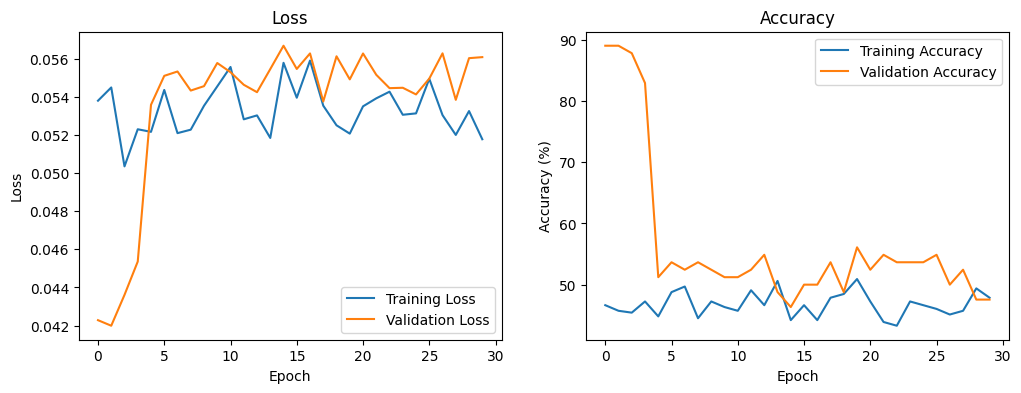

Fold 3: Training samples: 328, Testing samples: 82


Epoch: 1/30 | train loss: 0.0503 | train accuracy: 51.52%: 100%|██████████| 21/21 [00:10<00:00,  2.07it/s]
Epoch: 1/30 | valid loss: 0.0625 | valid accuracy: 12.20% : 100%|██████████| 6/6 [00:01<00:00,  4.15it/s]
Epoch: 2/30 | train loss: 0.0478 | train accuracy: 53.35%: 100%|██████████| 21/21 [00:09<00:00,  2.14it/s]
Epoch: 2/30 | valid loss: 0.0613 | valid accuracy: 12.20% : 100%|██████████| 6/6 [00:01<00:00,  4.46it/s]
Epoch: 3/30 | train loss: 0.0485 | train accuracy: 53.35%: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]
Epoch: 3/30 | valid loss: 0.0513 | valid accuracy: 47.56% : 100%|██████████| 6/6 [00:01<00:00,  4.48it/s]
Epoch: 4/30 | train loss: 0.0477 | train accuracy: 53.66%: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]
Epoch: 4/30 | valid loss: 0.0506 | valid accuracy: 43.90% : 100%|██████████| 6/6 [00:01<00:00,  4.41it/s]
Epoch: 5/30 | train loss: 0.0516 | train accuracy: 50.91%: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]
Epoch: 5/30 | valid loss: 0.0495 | valid 



Fold 3 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.54      0.69        72
           1       0.20      0.80      0.31        10

    accuracy                           0.57        82
   macro avg       0.57      0.67      0.50        82
weighted avg       0.86      0.57      0.64        82

Accuracy: 0.5732
Precision: 0.1951
Recall: 0.8000
F1 Score: 0.3137
ROC AUC Score: 0.6986
Confusion Matrix:
[[39 33]
 [ 2  8]]


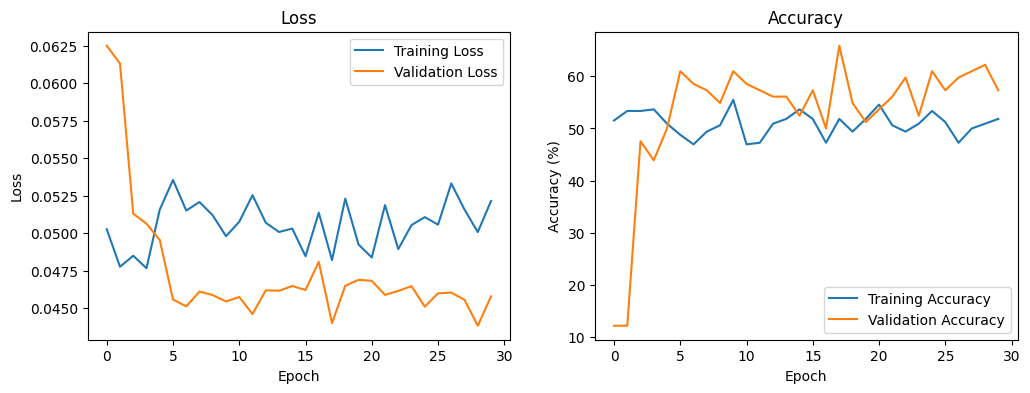

Fold 4: Training samples: 328, Testing samples: 82


Epoch: 1/30 | train loss: 0.0570 | train accuracy: 42.38%: 100%|██████████| 21/21 [00:10<00:00,  2.06it/s]
Epoch: 1/30 | valid loss: 0.0614 | valid accuracy: 9.76% : 100%|██████████| 6/6 [00:01<00:00,  4.30it/s]
Epoch: 2/30 | train loss: 0.0516 | train accuracy: 47.87%: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]
Epoch: 2/30 | valid loss: 0.0602 | valid accuracy: 9.76% : 100%|██████████| 6/6 [00:01<00:00,  4.18it/s]
Epoch: 3/30 | train loss: 0.0531 | train accuracy: 50.61%: 100%|██████████| 21/21 [00:10<00:00,  2.06it/s]
Epoch: 3/30 | valid loss: 0.0593 | valid accuracy: 28.05% : 100%|██████████| 6/6 [00:01<00:00,  4.25it/s]
Epoch: 4/30 | train loss: 0.0534 | train accuracy: 47.56%: 100%|██████████| 21/21 [00:10<00:00,  2.09it/s]
Epoch: 4/30 | valid loss: 0.0641 | valid accuracy: 46.34% : 100%|██████████| 6/6 [00:01<00:00,  4.25it/s]
Epoch: 5/30 | train loss: 0.0519 | train accuracy: 50.91%: 100%|██████████| 21/21 [00:10<00:00,  2.08it/s]
Epoch: 5/30 | valid loss: 0.0628 | valid ac



Fold 4 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.46      0.59        74
           1       0.02      0.12      0.04         8

    accuracy                           0.43        82
   macro avg       0.43      0.29      0.32        82
weighted avg       0.75      0.43      0.54        82

Accuracy: 0.4268
Precision: 0.0244
Recall: 0.1250
F1 Score: 0.0408
ROC AUC Score: 0.1943
Confusion Matrix:
[[34 40]
 [ 7  1]]


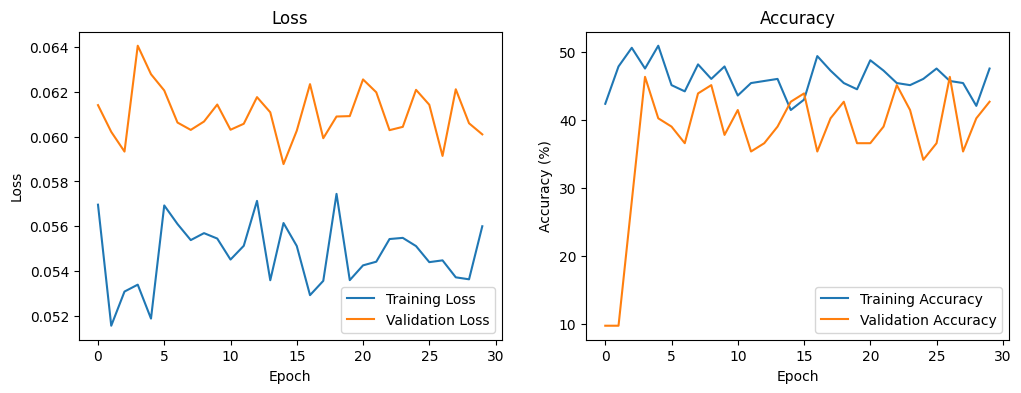

Best Validation Accuracy: 100.00% in Fold 0
Model saved to MELModel.pt


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
# File name.
modelSaveName = "MELModel.pt"
# model
model = CNN_Model().to(device)
# Create an optimizer.
learning_rate = 1e-3
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
# Create a loss function
lossFunc = nn.CrossEntropyLoss()

BestValid_Acc = 0
Bestfold = 0
batch_size = 16
fold_loaders = create_group_kfold_loaders(dataset, batch_size)
for train, test, idx in fold_loaders:
    print(f"Fold {idx}: Training samples: {len(train.dataset)}, Testing samples: {len(test.dataset)}")
    model, train_losses, train_accuracies, valid_losses, valid_accuracies = training(train, test, optimizer, num_epochs)
    print()

    # Print statistics for this fold
    all_targets = []
    all_predictions = []
    all_probs = []
    
    # Set model to evaluation mode
    model.eval()
    
    # Collect predictions for test data
    with torch.no_grad():
        for inputs, targets in test:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            
            # Get probability scores for ROC AUC
            probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[:, 1]  # Probability for positive class
            
            # Store results for metrics calculation
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs)
    
    # Calculate metrics
    try:
        roc_auc_score_value = roc_auc_score(all_targets, all_probs)
    except ValueError:
        # Handle case when only one class is present in targets
        roc_auc_score_value = 0.5
    
    # Generate confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    # Print detailed metrics
    print(f"\nFold {idx} Test Results:")
    
    print(f"Classification Report:\n{classification_report(all_targets, all_predictions, zero_division=np.nan)}")
    print(f"Accuracy: {accuracy_score(all_targets, all_predictions):.4f}")
    print(f"Precision: {precision_score(all_targets, all_predictions):.4f}")
    print(f"Recall: {recall_score(all_targets, all_predictions):.4f}")
    print(f"F1 Score: {f1_score(all_targets, all_predictions):.4f}")
    print(f"ROC AUC Score: {roc_auc_score_value:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # Plot the training history
    plot_training_history(train_losses, train_accuracies, valid_losses, valid_accuracies)
    plt.show()

    # Check for best validation accuracy to store best model
    if max(valid_accuracies) > BestValid_Acc:
        BestValid_Acc = max(valid_accuracies)
        Bestfold = idx
        modelToSave = model


# 存檔
print(f"Best Validation Accuracy: {BestValid_Acc:.2f}% in Fold {Bestfold}")
torch.save(modelToSave.state_dict(), modelSaveName)
print('Model saved to %s' % modelSaveName)

測試模型
* inference time

In [12]:
import time
import torch
import numpy as np

# Load the model and move it to the device
model = CNN_Model().to(device)
model.load_state_dict(torch.load(modelSaveName))
model.eval()  # Set to evaluation mode

# Test data for inference
test_batch = next(iter(test_loader))[0].to(device)

# Warm-up runs
print("Warming up...")
with torch.no_grad():
    for _ in range(10):
        _ = model(test_batch)

# Measure inference time
print("Measuring inference time...")
n_iterations = 100
start_time = time.time()

with torch.no_grad():
    for _ in range(n_iterations):
        _ = model(test_batch)

end_time = time.time()

# Calculate statistics
total_time = end_time - start_time
avg_time_per_batch = total_time / n_iterations
avg_time_per_sample = total_time / (n_iterations * test_batch.size(0))

print(f"Total time for {n_iterations} iterations: {total_time:.4f} seconds")
print(f"Average time per batch: {avg_time_per_batch*1000:.2f} ms")
print(f"Average time per sample: {avg_time_per_sample*1000:.2f} ms")
print(f"Inference speed: {n_iterations * test_batch.size(0) / total_time:.2f} samples/second")

Warming up...
Measuring inference time...
Total time for 100 iterations: 1.9706 seconds
Average time per batch: 19.71 ms
Average time per sample: 4.93 ms
Inference speed: 202.98 samples/second
